##### This notebook is dedicated towards the case study for Pair Finance email delivering service. The problem statement is to optimize the responsiveness of the users. 
The work is divided in following sections
    1. Data processing for user level summarization
    2. Define the logic for assigning user behavior for mail reverts. i.e. define the time window as the user affinity
        2.1 Rules for defining affinity for a person. This is funnel approach, so users are tagged on successive iterations.
        2.2 Combine rule for the different types of users
    3. Building data pipeline for data processing
    4. Modeling with XGBoost regressor
    5. Result analysis
    6. Package creation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip install jupyterthemes
!jt -t onedork

In [3]:
# Read the data
raw_data = pd.read_csv("/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/data/data.csv",
                                na_values = ['NA', 'na', 'nan', 'NaN', 'Nan', np.nan, np.inf, 'missing', 'NULL', 'null', 'Null', None, 
                                            'None', 'none', ' ', ''],
                                low_memory=False
                               )

In [4]:
raw_data.head()

,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
0,-1.25,-0.88,2,14,14:00,22:27,18:00,14:37,13:00,09:39,17:00,11:58,11:00,07:47,18:00,21:27,14:00,09:57,19:00,20:13,14:00,19:39,18:00,15:42,10:00,21:29,10:00,08:47,15:00,10:06,10:00,09:14,NaN,NaN
1,-0.14,-3.21,0,1,17:00,17:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.23,0.08,3,1,19:00,09:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.38,-1.30,3,2,12:00,12:38,08:00,09:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.50,0.22,2,6,14:00,21:59,11:00,17:01,15:00,23:47,10:00,11:43,14:00,19:42,08:00,18:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(raw_data.shape)
print(raw_data.X3.value_counts(dropna=False))

(100000, 34)
0    25458
3    24904
2    24890
1    24748
Name: X3, dtype: int64


In [6]:
## Add id column to the data
raw_data['id'] = list(range(1,len(raw_data)+1))
x = raw_data.columns.tolist()
x.remove('id')
raw_data = raw_data[['id']+x]
raw_data.head()

,id,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,TS03,TO03,TS04,TO04,TS05,TO05,TS06,TO06,TS07,TO07,TS08,TO08,TS09,TO09,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
0,1,-1.25,-0.88,2,14,14:00,22:27,18:00,14:37,13:00,09:39,17:00,11:58,11:00,07:47,18:00,21:27,14:00,09:57,19:00,20:13,14:00,19:39,18:00,15:42,10:00,21:29,10:00,08:47,15:00,10:06,10:00,09:14,NaN,NaN
1,2,-0.14,-3.21,0,1,17:00,17:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.23,0.08,3,1,19:00,09:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-0.38,-1.30,3,2,12:00,12:38,08:00,09:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,-1.50,0.22,2,6,14:00,21:59,11:00,17:01,15:00,23:47,10:00,11:43,14:00,19:42,08:00,18:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 1. Data processing for user level summarization

In [7]:
# ## Restructure the data
# raw_data_restructure = pd.DataFrame()
# for i in range(1,len(raw_data)+1):
#     print(i)
#     temp_df = raw_data[raw_data.id==i].copy()
#     temp_df = temp_df.dropna(axis='columns')
#     user_profile = temp_df[['id','X1','X2','X3','M']].copy()
#     email_usage = temp_df.iloc[:,5:]
#     for j in range(0,user_profile['M'].values[0]*2,2):
#         temp_df_2 = pd.concat([user_profile, email_usage.iloc[:,j:j+2]],axis=1)
#         temp_df_2.columns = ['id','X1','X2','X3','M', 'TS', 'TO']
#         raw_data_restructure = pd.concat([raw_data_restructure,temp_df_2], axis=0)
#     if i/1000 in list(range(1,101,1)):
#         file = "/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/data/processed/raw_data_restructure_"+str(i/1000)+".csv"
#         raw_data_restructure.to_csv(file
#                                , index=False
#                               )
#         raw_data_restructure = pd.DataFrame()

##### 2. Define the logic for assigning user behavior for mail reverts. i.e. define the time window as the user affinity

In [8]:
## Read and join all the single files
import glob

directoryPath = "/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/pairfinance/pairfinance/data/"
raw_data_restructure = pd.DataFrame()
for file_name in glob.glob(directoryPath+'*.csv'):
    x = pd.read_csv(file_name, na_values = ['NA', 'na', 'nan', 'NaN', 'Nan', np.nan, np.inf, 'missing', 'NULL', 'null', 'Null', None, 
                                            'None', 'none', ' ', ''],
                                low_memory=False)
    raw_data_restructure = pd.concat([raw_data_restructure,x],axis=0)
    

In [9]:
print(raw_data_restructure.shape)
print(raw_data_restructure.id.nunique())

(798960, 7)
100000


In [10]:
raw_data_restructure.head()

,id,X1,X2,X3,M,TS,TO
0,55001,-0.97,-1.16,0,2,08:00,08:43
1,55001,-0.97,-1.16,0,2,14:00,14:16
2,55002,0.83,-0.29,1,13,15:00,07:13
3,55002,0.83,-0.29,1,13,12:00,11:20
4,55002,0.83,-0.29,1,13,09:00,19:03


In [11]:
from pairfinance.helper_functions.utils import timing_of_reply
raw_data_restructure['opening_timing'] = raw_data_restructure['TO'].map(lambda x: timing_of_reply(x))

In [12]:
# raw_data_restructure['time_taken'] = time_calculate(raw_data_restructure['TS'], raw_data_restructure['TO'])
raw_data_restructure['hour_TS'] = raw_data_restructure['TS'].map(lambda x:int(x.split(':')[0]))
raw_data_restructure['hour_TO'] = raw_data_restructure['TO'].map(lambda x:int(x.split(':')[0]))

raw_data_restructure['date_TS'] = np.where(raw_data_restructure.hour_TS>raw_data_restructure.hour_TO, 
                                            pd.to_datetime(raw_data_restructure.TS) + pd.Timedelta(days=-1),
                                            pd.to_datetime(raw_data_restructure.TS)
                                           )
# Remove some rows with negative minute values
raw_data_restructure['minute_TO'] = raw_data_restructure['TO'].apply(lambda x: x.split(":")[1])
raw_data_restructure.minute_TO = raw_data_restructure.minute_TO.astype(int)
raw_data_restructure = raw_data_restructure[raw_data_restructure.minute_TO>=0]
raw_data_restructure = raw_data_restructure.drop(['minute_TO'], axis=1)
raw_data_restructure['date_TO'] = pd.to_datetime(raw_data_restructure['TO'])

raw_data_restructure['time_diff'] = (raw_data_restructure['date_TO'] - raw_data_restructure['date_TS']).astype('timedelta64[m]')
print(raw_data_restructure.id.nunique())
raw_data_restructure.head(10)

100000


,id,X1,X2,X3,M,TS,TO,opening_timing,hour_TS,hour_TO,date_TS,date_TO,time_diff
0,55001,-0.97,-1.16,0,2,08:00,08:43,6am to 12pm,8,8,2020-01-21 08:00:00,2020-01-21 08:43:00,43.0
1,55001,-0.97,-1.16,0,2,14:00,14:16,12pm to 18pm,14,14,2020-01-21 14:00:00,2020-01-21 14:16:00,16.0
2,55002,0.83,-0.29,1,13,15:00,07:13,6am to 12pm,15,7,2020-01-20 15:00:00,2020-01-21 07:13:00,973.0
3,55002,0.83,-0.29,1,13,12:00,11:20,6am to 12pm,12,11,2020-01-20 12:00:00,2020-01-21 11:20:00,1400.0
4,55002,0.83,-0.29,1,13,09:00,19:03,18pm to 23pm,9,19,2020-01-21 09:00:00,2020-01-21 19:03:00,603.0
5,55002,0.83,-0.29,1,13,19:00,17:55,12pm to 18pm,19,17,2020-01-20 19:00:00,2020-01-21 17:55:00,1375.0
6,55002,0.83,-0.29,1,13,12:00,13:08,12pm to 18pm,12,13,2020-01-21 12:00:00,2020-01-21 13:08:00,68.0
7,55002,0.83,-0.29,1,13,08:00,23:15,None,8,23,2020-01-21 08:00:00,2020-01-21 23:15:00,915.0
8,55002,0.83,-0.29,1,13,14:00,14:31,12pm to 18pm,14,14,2020-01-21 14:00:00,2020-01-21 14:31:00,31.0
9,55002,0.83,-0.29,1,13,14:00,18:07,18pm to 23pm,14,18,2020-01-21 14:00:00,2020-01-21 18:07:00,247.0


  opening_timing   count  sorting_index
0       0 to 6am   15389              0
3    6am to 12pm  335947              1
1   12pm to 18pm  217668              2
2   18pm to 23pm  211425              3


Text(0,0.5,'Email counts')

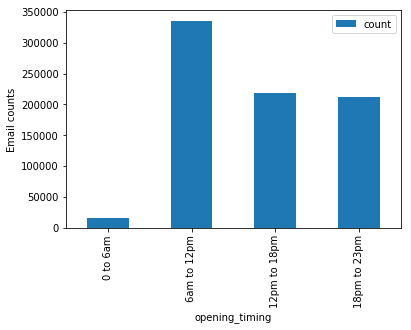

In [13]:
temp = raw_data_restructure.groupby(['opening_timing']).size().reset_index(name='count')
sorting = {'0 to 6am':0,'6am to 12pm':1,'12pm to 18pm':2,'18pm to 23pm':3}
temp['sorting_index'] = temp.opening_timing.map(sorting)
temp = temp.sort_values('sorting_index')
print(temp.head())
temp.set_index(['opening_timing'])[['count']].plot.bar()
plt.ylabel("Email counts")


  opening_timing  count  sorting_index
0       0 to 6am  13354              0
3    6am to 12pm  88038              1
1   12pm to 18pm  75044              2
2   18pm to 23pm  73238              3


Text(0,0.5,'User counts')

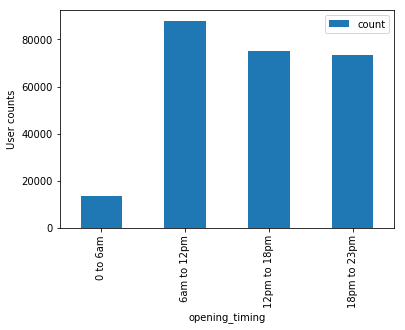

In [14]:
temp = raw_data_restructure.groupby(['opening_timing'])['id'].nunique().reset_index(name='count')
sorting = {'0 to 6am':0,'6am to 12pm':1,'12pm to 18pm':2,'18pm to 23pm':3}
temp['sorting_index'] = temp.opening_timing.map(sorting)
temp = temp.sort_values('sorting_index')
print(temp.head())
temp.set_index(['opening_timing'])[['count']].plot.bar()
plt.ylabel("User counts")


###### 2.1 Rules for defining affinity for a person. This is funnel approach, so users are tagged on successive iterations.
    1. Time difference always < 90 then he's an active person
    2. More than 70% emails are opened at a single time window, then assign that window.
    3. Min. of opening time with > 20% of emails opened
    4. Max. percentage of emails opened from the rest of the dataset

In [15]:
## Summarize the raw_data
raw_data_summary = raw_data_restructure[['id','X1','X2','M','opening_timing','time_diff']].groupby(['id','X1','X2','M','opening_timing']).agg(('mean','count')).reset_index()
raw_data_summary.columns = ['id', 'X1', 'X2', 'M', 'opening_timing', 'time_diff_mean', 'time_diff_count']
raw_data_summary.head()

,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count
0,1,-1.25,-0.88,14,12pm to 18pm,1269.500000,2
1,1,-1.25,-0.88,14,18pm to 23pm,363.000000,5
2,1,-1.25,-0.88,14,6am to 12pm,1246.857143,7
3,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1
4,3,1.23,0.08,1,6am to 12pm,862.000000,1


In [16]:
## Add percent_email columns for each row
raw_data_summary_total = raw_data_summary.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff_count':'sum'}).reset_index()
raw_data_summary_merged = pd.merge(raw_data_summary,raw_data_summary_total,on=['id', 'X1', 'X2', 'M'], how='left', suffixes=('','_total'))
raw_data_summary_merged['percent_emails'] = np.round(raw_data_summary_merged['time_diff_count']/raw_data_summary_merged['time_diff_count_total'],3)
raw_data_summary_merged.head()

,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails
0,1,-1.25,-0.88,14,12pm to 18pm,1269.500000,2,14,0.143
1,1,-1.25,-0.88,14,18pm to 23pm,363.000000,5,14,0.357
2,1,-1.25,-0.88,14,6am to 12pm,1246.857143,7,14,0.500
3,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1,1,1.000
4,3,1.23,0.08,1,6am to 12pm,862.000000,1,1,1.000


In [17]:
## Add mean time_diff_mean column at user level
raw_data_restructure_mean = raw_data_restructure.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff':'mean'}).reset_index()
raw_data_restructure_mean.columns = ['id', 'X1', 'X2', 'M', 'avg_opening_time']
raw_data_summary_merged = pd.merge(raw_data_summary_merged,raw_data_restructure_mean,on=['id', 'X1', 'X2', 'M'], how='left', suffixes=('',''))
print(raw_data_summary_merged.id.nunique())
raw_data_summary_merged.head(10)

99851


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time
0,1,-1.25,-0.88,14,12pm to 18pm,1269.500000,2,14,0.143,934.428571
1,1,-1.25,-0.88,14,18pm to 23pm,363.000000,5,14,0.357,934.428571
2,1,-1.25,-0.88,14,6am to 12pm,1246.857143,7,14,0.500,934.428571
3,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1,1,1.000,11.000000
4,3,1.23,0.08,1,6am to 12pm,862.000000,1,1,1.000,862.000000
5,4,-0.38,-1.30,2,12pm to 18pm,38.000000,1,2,0.500,51.000000
6,4,-0.38,-1.30,2,6am to 12pm,64.000000,1,2,0.500,51.000000
7,5,-1.50,0.22,6,12pm to 18pm,361.000000,1,5,0.200,402.333333
8,5,-1.50,0.22,6,18pm to 23pm,474.333333,3,5,0.600,402.333333
9,5,-1.50,0.22,6,6am to 12pm,103.000000,1,5,0.200,402.333333


In [18]:
## Rule 1
raw_data_summary_merged['preference'] = np.where(raw_data_summary_merged.avg_opening_time<90, 'instant','unk')
rule_1 = raw_data_summary_merged[raw_data_summary_merged.preference=='instant']
print(raw_data_summary_merged[raw_data_summary_merged.preference=='instant'].id.nunique())

18230


In [19]:
## Rule 2
# Add a flag for percentage of emails
percent_emails_filter = raw_data_summary_merged[raw_data_summary_merged.preference!='instant']
xx = percent_emails_filter[percent_emails_filter.percent_emails>=0.7].id.unique()
percent_emails_filter['preference'] = np.where(percent_emails_filter.id.isin(xx),'one_time','unk')
rule_2 = percent_emails_filter[percent_emails_filter.preference=='one_time']
print(percent_emails_filter[percent_emails_filter.preference=='one_time'].id.nunique())

22566


/Users/sheikhshahidurrahman/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
## Rule 3
rest_df = percent_emails_filter[percent_emails_filter.preference!='one_time']
rest_df_min_opening = rest_df.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff_mean':'min'}).reset_index()
rest_df_joined = pd.merge(rest_df, rest_df_min_opening, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_min'))
rest_df_joined.head()
rest_df_joined['min_col'] = np.where(rest_df_joined.time_diff_mean==rest_df_joined.time_diff_mean_min,1,0)
last_df = rest_df_joined[(rest_df_joined.min_col==1) & (rest_df_joined.percent_emails>=0.2)]
xx = last_df.id.unique()
rest_df_joined['preference'] = np.where(rest_df_joined.id.isin(xx),'min_20_percent','unk')
rule_3 = rest_df_joined[rest_df_joined.preference=='min_20_percent']
print(rest_df_joined[rest_df_joined.preference=='min_20_percent'].id.nunique())

45845


In [21]:
## Rule 4 : Max number of emails timing
rule_4 = rest_df_joined[rest_df_joined.preference!='min_20_percent']
rule_4_max_percent_emails = rule_4.groupby(['id', 'X1', 'X2', 'M']).agg({'percent_emails':'max'}).reset_index()
rule_4_max_percent_emails.columns = ['id', 'X1', 'X2', 'M','percent_emails_max']
rule_4_joined = pd.merge(rule_4, rule_4_max_percent_emails, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_'))
rule_4_joined.head()

rule_4_joined['max_col'] = np.where(rule_4_joined.percent_emails==rule_4_joined.percent_emails_max,1,0)
remain_df = rule_4_joined[rule_4_joined.max_col==1]
xx = remain_df.id.unique()
rule_4_joined['preference'] = np.where(rule_4_joined.id.isin(xx),'remain','unk')
rule_4 = rule_4_joined
rule_4_joined.head()

,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_mean_min,min_col,percent_emails_max,max_col
0,7,1.00,0.84,12,12pm to 18pm,793.0,5,12,0.417,773.666667,remain,45.5,0,0.417,1
1,7,1.00,0.84,12,18pm to 23pm,45.5,2,12,0.167,773.666667,remain,45.5,1,0.417,0
2,7,1.00,0.84,12,6am to 12pm,1045.6,5,12,0.417,773.666667,remain,45.5,0,0.417,1
3,19,-0.77,0.27,14,0 to 6am,631.5,2,13,0.154,747.571429,remain,41.0,0,0.462,0
4,19,-0.77,0.27,14,12pm to 18pm,41.0,1,13,0.077,747.571429,remain,41.0,1,0.462,0


###### 2.2 Combine rule for the different types of users

In [22]:
## Take only one time for each user
# Rule 1
rule_1_unique = rule_1.groupby(['id', 'X1', 'X2', 'M']).agg({'time_diff_mean':'min'}).reset_index()
rule_1_unique.columns = ['id', 'X1', 'X2', 'M','time_diff_min']
rule_1_unique = pd.merge(rule_1, rule_1_unique, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_'))

rule_1_unique['same_flag'] = np.where(rule_1_unique.time_diff_mean==rule_1_unique.time_diff_min,1,0)
rule_1_unique = rule_1_unique[rule_1_unique.same_flag==1]
print(rule_1_unique.id.nunique())
rule_1_unique.head()

18230


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_min,same_flag
0,2,-0.14,-3.21,1,12pm to 18pm,11.000000,1,1,1.000,11.000000,instant,11.000000,1
1,4,-0.38,-1.30,2,12pm to 18pm,38.000000,1,2,0.500,51.000000,instant,38.000000,1
3,13,-0.60,-1.76,7,12pm to 18pm,25.666667,3,7,0.429,43.571429,instant,25.666667,1
8,15,-1.05,-0.45,6,6am to 12pm,4.000000,1,6,0.167,53.500000,instant,4.000000,1
9,21,-0.25,-0.29,1,6am to 12pm,48.000000,1,1,1.000,48.000000,instant,48.000000,1


In [23]:
# Rule 2
rule_2_unique = rule_2.groupby(['id', 'X1', 'X2', 'M']).agg({'percent_emails':'max'}).reset_index()
rule_2_unique.columns = ['id', 'X1', 'X2', 'M','percent_emails_max']
rule_2_unique = pd.merge(rule_2, rule_2_unique, how='left', on=['id', 'X1', 'X2', 'M'], suffixes=('','_'))

rule_2_unique['same_flag'] = np.where(rule_2_unique.percent_emails==rule_2_unique.percent_emails_max,1,0)
rule_2_unique = rule_2_unique[rule_2_unique.same_flag==1]
print(rule_2_unique.id.nunique())
rule_2_unique.head()

22566


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,percent_emails_max,same_flag
0,3,1.23,0.08,1,6am to 12pm,862.000000,1,1,1.000,862.000000,one_time,1.000,1
2,9,0.23,1.55,9,6am to 12pm,656.142857,7,9,0.778,655.111111,one_time,0.778,1
4,10,0.17,2.88,6,6am to 12pm,1136.800000,5,6,0.833,1166.000000,one_time,0.833,1
6,12,-0.42,0.03,10,6am to 12pm,664.000000,8,9,0.889,634.200000,one_time,0.889,1
9,14,0.64,1.10,14,6am to 12pm,1147.900000,10,14,0.714,917.285714,one_time,0.714,1


In [24]:
# Rule 3
rule_3_unique = rule_3[rule_3.min_col==1]
print(rule_3_unique[rule_3_unique.min_col==1].id.nunique())
rule_3_unique.head()

45845


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_mean_min,min_col
1,1,-1.25,-0.88,14,18pm to 23pm,363.0,5,14,0.357,934.428571,min_20_percent,363.0,1
5,5,-1.50,0.22,6,6am to 12pm,103.0,1,5,0.200,402.333333,min_20_percent,103.0,1
6,6,0.31,-1.96,6,12pm to 18pm,37.0,1,5,0.200,433.000000,min_20_percent,37.0,1
12,8,-0.39,-1.88,3,18pm to 23pm,434.0,2,3,0.667,660.333333,min_20_percent,434.0,1
16,11,0.61,-0.18,7,18pm to 23pm,361.0,2,6,0.333,669.857143,min_20_percent,361.0,1


In [25]:
# Rule 4
rule_4_unique = rule_4[rule_4.max_col==1]
print(rule_4_unique[rule_4_unique.max_col==1].id.nunique())
rule_4_unique.head()

13210


,id,X1,X2,M,opening_timing,time_diff_mean,time_diff_count,time_diff_count_total,percent_emails,avg_opening_time,preference,time_diff_mean_min,min_col,percent_emails_max,max_col
0,7,1.00,0.84,12,12pm to 18pm,793.000000,5,12,0.417,773.666667,remain,45.5,0,0.417,1
2,7,1.00,0.84,12,6am to 12pm,1045.600000,5,12,0.417,773.666667,remain,45.5,0,0.417,1
6,19,-0.77,0.27,14,6am to 12pm,865.333333,6,13,0.462,747.571429,remain,41.0,0,0.462,1
9,23,-0.47,3.49,15,18pm to 23pm,520.571429,7,13,0.538,771.600000,remain,333.0,0,0.538,1
13,27,2.11,-0.27,6,6am to 12pm,583.666667,3,6,0.500,450.000000,remain,283.0,0,0.500,1


In [26]:
## Merge with the raw_data_restructure
final_data = raw_data_restructure.copy()
final_data = pd.merge(final_data, rule_1_unique[['id', 'X1', 'X2', 'M','opening_timing','same_flag']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_1'))
final_data = pd.merge(final_data, rule_2_unique[['id', 'X1', 'X2', 'M','opening_timing','same_flag']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_2'))
final_data = pd.merge(final_data, rule_3_unique[['id', 'X1', 'X2', 'M','opening_timing','min_col']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_3'))
final_data = pd.merge(final_data, rule_4_unique[['id', 'X1', 'X2', 'M','opening_timing','max_col']], on=['id', 'X1', 'X2', 'M','opening_timing'], how='left', suffixes=('','_rule_4'))
final_data = final_data.fillna(0)
final_data['keep_row'] = final_data['same_flag']+final_data['same_flag_rule_2']+final_data['min_col']+final_data['max_col']
final_data = final_data[final_data.keep_row>0]

print(final_data.shape)
print(final_data.id.nunique())
final_data.head(10)

(386876, 18)
99851


,id,X1,X2,X3,M,TS,TO,opening_timing,hour_TS,hour_TO,date_TS,date_TO,time_diff,same_flag,same_flag_rule_2,min_col,max_col,keep_row
1,55001,-0.97,-1.16,0,2,14:00,14:16,12pm to 18pm,14,14,2020-01-21 14:00:00,2020-01-21 14:16:00,16.0,1.0,0.0,0.0,0.0,1.0
5,55002,0.83,-0.29,1,13,19:00,17:55,12pm to 18pm,19,17,2020-01-20 19:00:00,2020-01-21 17:55:00,1375.0,0.0,0.0,1.0,0.0,1.0
6,55002,0.83,-0.29,1,13,12:00,13:08,12pm to 18pm,12,13,2020-01-21 12:00:00,2020-01-21 13:08:00,68.0,0.0,0.0,1.0,0.0,1.0
8,55002,0.83,-0.29,1,13,14:00,14:31,12pm to 18pm,14,14,2020-01-21 14:00:00,2020-01-21 14:31:00,31.0,0.0,0.0,1.0,0.0,1.0
12,55002,0.83,-0.29,1,13,10:00,14:45,12pm to 18pm,10,14,2020-01-21 10:00:00,2020-01-21 14:45:00,285.0,0.0,0.0,1.0,0.0,1.0
16,55003,-0.42,-0.14,3,7,20:00,21:23,18pm to 23pm,20,21,2020-01-21 20:00:00,2020-01-21 21:23:00,83.0,0.0,0.0,1.0,0.0,1.0
20,55003,-0.42,-0.14,3,7,20:00,20:01,18pm to 23pm,20,20,2020-01-21 20:00:00,2020-01-21 20:01:00,1.0,0.0,0.0,1.0,0.0,1.0
22,55004,0.26,0.79,1,3,20:00,09:19,6am to 12pm,20,9,2020-01-20 20:00:00,2020-01-21 09:19:00,799.0,0.0,1.0,0.0,0.0,1.0
23,55004,0.26,0.79,1,3,12:00,08:33,6am to 12pm,12,8,2020-01-20 12:00:00,2020-01-21 08:33:00,1233.0,0.0,1.0,0.0,0.0,1.0
24,55004,0.26,0.79,1,3,11:00,09:47,6am to 12pm,11,9,2020-01-20 11:00:00,2020-01-21 09:47:00,1367.0,0.0,1.0,0.0,0.0,1.0


  opening_timing  count  sorting_index
0       0 to 6am    680              0
3    6am to 12pm  37254              1
1   12pm to 18pm  27423              2
2   18pm to 23pm  36194              3


Text(0,0.5,'Final User counts')

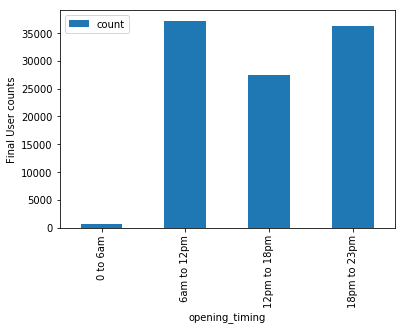

In [27]:
temp = final_data.groupby(['opening_timing'])['id'].nunique().reset_index(name='count')
sorting = {'0 to 6am':0,'6am to 12pm':1,'12pm to 18pm':2,'18pm to 23pm':3}
temp['sorting_index'] = temp.opening_timing.map(sorting)
temp = temp.sort_values('sorting_index')
print(temp.head())
temp.set_index(['opening_timing'])[['count']].plot.bar()
plt.ylabel("Final User counts")


In [28]:
final_data['TO_minute'] = final_data['TO'].apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))
final_data = final_data.groupby(['id', 'X1', 'X2','X3']).agg({'TO_minute':'mean'}).reset_index()
final_data.head()

,id,X1,X2,X3,TO_minute
0,1,-1.25,-0.88,2,1263.0
1,2,-0.14,-3.21,0,1031.0
2,3,1.23,0.08,3,562.0
3,4,-0.38,-1.30,3,758.0
4,5,-1.50,0.22,2,703.0


In [29]:
from sklearn.model_selection import train_test_split
np.random.seed(123)

y_data_modeling = final_data[['TO_minute']]
# final_data = final_data.drop(['TO_minute'],axis=1)

train_data_modeling, val_data_modeling, y_train_data_modeling, y_val_data_modeling = train_test_split(final_data, y_data_modeling, test_size=0.20, random_state=123)
val_data_modeling, test_data_modeling, y_val_data_modeling, y_test_data_modeling = train_test_split(val_data_modeling, y_val_data_modeling, test_size=0.50, random_state=123)
print(final_data.shape)
print(train_data_modeling.shape)
print(y_train_data_modeling.shape)
print(val_data_modeling.shape)
print(y_val_data_modeling.shape)
print(test_data_modeling.shape)
print(y_test_data_modeling.shape)


(99851, 5)
(79880, 5)
(79880, 1)
(9985, 5)
(9985, 1)
(9986, 5)
(9986, 1)


##### 3. Building data pipeline for data processing

In [30]:
## Define columns 
selected_columns = ['id','X1','X2','X3']
numerical_columns = ['X1','X2']
low_cardinal_columns_before = ['X3']
low_cardinal_columns_after = pd.get_dummies(final_data[['X3']].fillna('unk').astype('str')).columns.tolist()

In [31]:
## Data pipeline building
from pairfinance.data_processing.pipeline import get_preprocess_pipeline

train_pipeline = get_preprocess_pipeline(selected_columns=selected_columns,
                                         numerical_columns=numerical_columns,
                                         strategy='median',
                                         low_card_columns_before=low_cardinal_columns_before,
                                         low_card_columns_after=low_cardinal_columns_after
                                        )

train_pipeline.fit_transform(train_data_modeling)

new_numerical_columns = train_pipeline.steps[1][1].transformer_list[0][1].steps[5][1].get_feature_names()
new_low_card_columns = train_pipeline.steps[1][1].transformer_list[1][1].steps[3][1].get_feature_names()

all_new_columns = new_numerical_columns + new_low_card_columns


In [32]:
import time
train_data_modeling_transformed = train_pipeline.transform(train_data_modeling)
val_data_modeling_transformed = train_pipeline.transform(val_data_modeling)
test_data_modeling_transformed= train_pipeline.transform(test_data_modeling)

print(train_data_modeling_transformed.shape)
print(val_data_modeling_transformed.shape)
print(test_data_modeling_transformed.shape)

t1 = time.time()
train_pipeline.transform(train_data_modeling.head(1))
t2 = time.time()
print('Time taken = {}s'.format(t2 - t1))

(79880, 6)
(9985, 6)
(9986, 6)
Time taken = 0.01951909065246582s


##### 4. Modeling using XGBoost

In [33]:
import xgboost as xgb
np.random.seed(123)

# XGBoost model run
n=2000
xgb_model = xgb.XGBRegressor(max_depth=4,
                             learning_rate=0.001,
                             n_estimators=n,
                             verbosity=0,
                             objective='reg:squarederror', # reg:linear reg:squarederror
                             booster='gbtree', # gblinear gbtree
                             tree_method='auto',
                             n_jobs=1,
                             gamma=3,
                             min_child_weight=0,
                             max_delta_step=0,
                             subsample=0.7,
                             colsample_bytree=0.6,
                             colsample_bylevel=1,
                             colsample_bynode=1,
                             reg_alpha=3,
                             reg_lambda=5,
                             scale_pos_weight=1,
                             random_state=123,
                             missing=None,
                             num_parallel_tree=1,
                             importance_type='gain'
                            )

xgb_model.fit(train_data_modeling_transformed, y_train_data_modeling.values,
              eval_set=[(train_data_modeling_transformed, y_train_data_modeling.values), (val_data_modeling_transformed, y_val_data_modeling.values)],
#               sample_weight = weight_array,
              eval_metric=['mae', 'rmse'],
              verbose=False
             )

evals_result = xgb_model.evals_result()

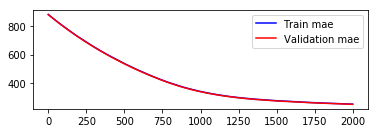

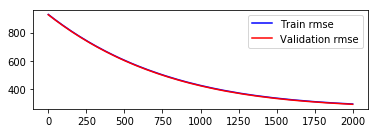

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.clf()
plt.subplot(211)
x=list(range(n))
plt.plot(x, evals_result['validation_0']['mae'], color='b', label='Train mae')
plt.plot(x, evals_result['validation_1']['mae'], color='r', label='Validation mae')
plt.legend()
plt.show()

plt.clf()
plt.subplot(212)
x=list(range(n))
plt.plot(x, evals_result['validation_0']['rmse'], color='b', label='Train rmse')
plt.plot(x, evals_result['validation_1']['rmse'], color='r', label='Validation rmse')
plt.legend()
plt.show()

##### 5. Result analysis

In [35]:
prediction = xgb_model.predict(train_data_modeling_transformed)

In [36]:
train_data_modeling['TO_minute_pred'] = prediction
train_data_modeling['error'] = np.abs(train_data_modeling['TO_minute'] - train_data_modeling['TO_minute_pred'])
train_data_modeling.sort_values('error',ascending=True).head(10)

/Users/sheikhshahidurrahman/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sheikhshahidurrahman/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,X1,X2,X3,TO_minute,TO_minute_pred,error
67415,67514,0.42,1.50,2,679.857143,679.848999,0.008144
85342,85467,2.14,0.80,0,656.500000,656.481689,0.018311
17256,17285,0.73,-0.86,0,829.333333,829.305481,0.027852
48431,48504,-1.00,-0.46,0,764.600000,764.627869,0.027869
82027,82149,2.32,-3.93,1,842.666667,842.630981,0.035685
98722,98870,2.09,-0.66,2,847.000000,846.954163,0.045837
60929,61018,0.79,-0.48,0,829.333333,829.259399,0.073934
20258,20290,1.21,-0.05,3,823.666667,823.746094,0.079427
51144,51219,0.76,-0.47,1,848.166667,848.082642,0.084025
13440,13462,1.43,-0.55,2,847.142857,847.231506,0.088649


<Figure size 432x288 with 0 Axes>

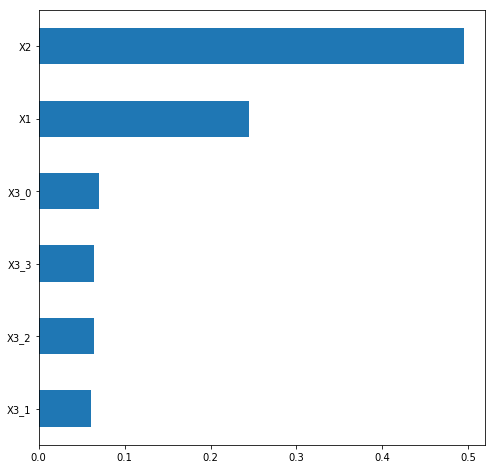

In [37]:
## Feature importance
all_new_columns = new_numerical_columns + new_low_card_columns

importance_df = pd.Series(xgb_model.feature_importances_, index=all_new_columns).sort_values(ascending=False).head(10)
plt.clf()
plt.figure(figsize=(8,8))
importance_df.sort_values(ascending=True).plot.barh()
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


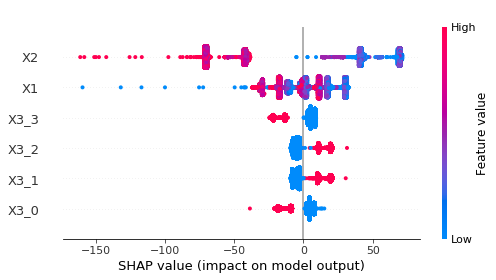

In [38]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_data_modeling_transformed)
shap.summary_plot(shap_values, features=train_data_modeling_transformed, feature_names=all_new_columns)


In [39]:
print(np.sqrt(((train_data_modeling.error) ** 2).mean()))

296.5729650119655


##### Performance on validation dataset

In [40]:
prediction = xgb_model.predict(val_data_modeling_transformed)

In [41]:
val_data_modeling['TO_minute_pred'] = prediction
val_data_modeling['error'] = np.abs(val_data_modeling['TO_minute'] - val_data_modeling['TO_minute_pred'])
val_data_modeling.sort_values('error',ascending=True).head(10)

,id,X1,X2,X3,TO_minute,TO_minute_pred,error
76187,76301,-1.24,-0.21,1,835.000000,835.074829,0.074829
11386,11406,1.09,-3.80,1,847.500000,847.330261,0.169739
25079,25124,-1.32,0.88,3,708.000000,707.726624,0.273376
21688,21724,0.59,0.29,0,659.000000,659.424500,0.424500
93280,93414,1.98,-0.73,1,848.000000,847.535461,0.464539
12302,12323,0.07,4.20,3,660.500000,659.890320,0.609680
60530,60619,1.05,1.69,0,659.000000,658.225525,0.774475
33720,33776,-1.25,-1.24,3,762.000000,761.179504,0.820496
27416,27465,0.96,0.72,3,654.666667,655.616760,0.950094
89030,89159,-1.75,-1.46,0,767.500000,766.525146,0.974854


In [42]:
print(np.sqrt(((val_data_modeling.error) ** 2).mean()))

294.60010018528556


##### Performance on test dataset

In [43]:
prediction = xgb_model.predict(test_data_modeling_transformed)

In [44]:
test_data_modeling['TO_minute_pred'] = prediction
test_data_modeling['error'] = np.abs(test_data_modeling['TO_minute'] - test_data_modeling['TO_minute_pred'])
test_data_modeling.sort_values('error',ascending=True).head(10)

,id,X1,X2,X3,TO_minute,TO_minute_pred,error
77513,77627,0.01,1.67,1,676.000000,676.082153,0.082153
62606,62697,-1.49,-2.38,3,761.000000,761.199585,0.199585
77782,77896,1.27,-0.85,0,828.833333,829.085876,0.252543
20812,20845,1.47,-1.28,3,823.000000,822.732788,0.267212
85798,85924,0.32,-0.89,1,849.333333,848.674194,0.659139
7213,7227,0.06,-0.35,1,846.833333,846.029175,0.804159
69923,70026,0.84,-0.65,1,847.250000,848.059631,0.809631
26828,26876,0.68,-0.40,2,846.500000,847.475037,0.975037
39124,39186,0.45,0.91,1,678.500000,677.474243,1.025757
33281,33337,1.13,0.19,2,681.000000,679.915527,1.084473


In [45]:
print(np.sqrt(((test_data_modeling.error) ** 2).mean()))

296.370587219137


##### 6. Save files for package creation

In [46]:
## Saving data type for future incoming data points
from pairfinance.helper_functions.utils import dtype_mapping
dtype_mapping_output = dtype_mapping(numeric_columns=numerical_columns+low_cardinal_columns_before,
                              boolean_columns=[],
                              string_columns=[]
                             )
print(dtype_mapping_output)

{'X1': <class 'float'>, 'X2': <class 'float'>, 'X3': <class 'float'>}


In [47]:
from pairfinance.helper_functions.utils import check_input_data_type
import json

json_data = test_data_modeling.iloc[0].to_json()
print(json_data)
tt = pd.DataFrame.from_dict([json.loads(json_data)])

check_input_data_type(tt, dtype_mapping_output)

{"id":74545.0,"X1":-1.78,"X2":2.4,"X3":1.0,"TO_minute":520.0,"TO_minute_pred":779.7887573242,"error":259.7887573242}


In [48]:
import pickle 
all_files = selected_columns, numerical_columns, low_cardinal_columns_before, low_cardinal_columns_after, dtype_mapping_output, train_pipeline, xgb_model
with open('/Users/sheikhshahidurrahman/Documents/DataScience/Pair_Finance/pairfinance/pairfinance/model_files_v0.pkl','wb') as f:
    pickle.dump(all_files ,f)